# HQNN
- a HQNN uses classical neural networks along with a VQC to optimize a given function (loss function)
- The main advantage provided is the reduced number of parameters
- https://arxiv.org/pdf/2304.09224 : implementation borrowed from here
  

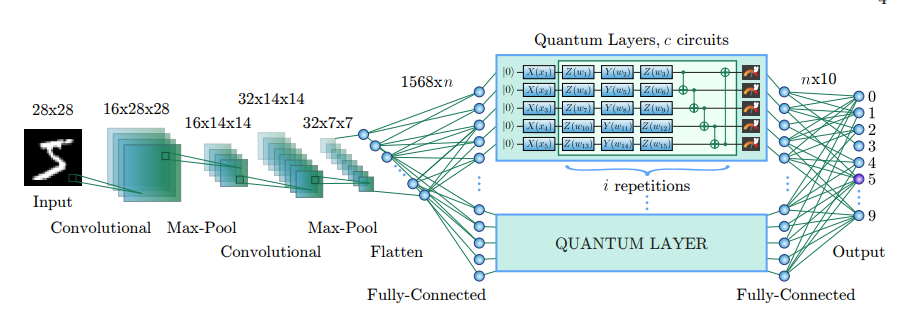

In [ ]:
!pip install --force-reinstall \
    qiskit==1.3.2 \
    qiskit-machine-learning==0.8.2 \
    sympy==1.13.1
!pip install torchvision



In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter, ParameterVector
from qiskit.primitives import Estimator
from qiskit.quantum_info import Pauli
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector


### LOADING DATA

In [4]:
import tensorflow as tf

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize pixel values to [0, 1]
x_train = x_train / 255.0
x_test = x_test / 255.0


### I. Implementing the 1st phase : convolutions + maxpool
- we use 2 pixel padding + 1 pixel stride
- use 5x5 kernel , for creation of 16 and then , 32 channels
- maxpool kernel size is 2x2
- after each convolution (1->16 , 16->32) , we apply Batch-normalization + RELU  + max-pool (2x2 kernel size)
- we then flatten it to make a a vector of 32x7x7 = 1568 features

In [4]:
class CNNFeatureExtractor(nn.Module): # is the same as a typical CNN
    def __init__(self):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2, stride=1),  # 28x28 → 16x28x28
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)                            # 16x28x28 → 16x14x14
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2, stride=1), # 16x14x14 → 32x14x14
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)                            # 32x14x14 → 32x7x7
        )
        self.flatten = nn.Flatten()  # 32 x 7 x 7 = 1568 features

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.flatten(x)
        return x


### II. Mapping 1568 -> n features 
- forms a fully connected layer which is then normalized and RELU'd
- now circuit is ready to undergo VQC , through formation of quantum layers

In [5]:
class PreQuantum(nn.Module):
    def __init__(self, quantum_input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(1568, quantum_input_dim),
            nn.BatchNorm1d(quantum_input_dim),
            nn.ReLU()
        )

    def forward(self, x):
        return self.model(x)


### III. Creating the Quantum Layer
- acts on q qubits
- total c of such layers
- c*q = n
- depth here refers to number of repititions of variational block

In [6]:
def create_quantum_circuit(q, depth):
    # Parameters for input encoding
    input_params = [Parameter(f"x_{i}") for i in range(q)]
    # Parameters for variational circuit
    theta_params = [Parameter(f"theta_{i}") for i in range(q * 3 * depth)]
    qc = QuantumCircuit(q)
    # Angle embedding using RX
    for i in range(q):
        qc.rx(input_params[i], i)
    # Variational part
    for layer in range(depth):
        for i in range(q):
            idx = layer * q * 3 + i * 3
            qc.rx(theta_params[idx], i)
            qc.ry(theta_params[idx + 1], i)
            qc.rz(theta_params[idx + 2], i)
        # Add entanglement
        for i in range(q - 1):
            qc.cx(i, i + 1)

    
    return qc, input_params, theta_params


In [7]:
from qiskit.quantum_info import SparsePauliOp

def create_quantum_layer(q=4, depth=1):
    qc, input_params, theta_params = create_quantum_circuit(q, depth)

    # Pauli-Y observables (one per qubit)
    observables = [SparsePauliOp(f"{'I'*i}Y{'I'*(q-i-1)}") for i in range(q)]

    qnn = EstimatorQNN(
        circuit=qc,
        input_params=input_params,
        weight_params=theta_params,
        observables=observables,
        input_gradients=True
    )

    quantum_layer = TorchConnector(qnn)
    return quantum_layer


In [8]:
class QuantumBlock(nn.Module):
    def __init__(self, n, c, depth=1):
        super().__init__()
        self.q = n // c
        self.c = c
        self.quantum_layers = nn.ModuleList([
            create_quantum_layer(q=self.q, depth=depth)
            for _ in range(c)
        ])
    def forward(self,x): # x : (batch_size,n)
        x_split = torch.chunk(x,self.c,dim = 1) # divides x into c chunks of input (each of size q)
        results = [layer(part) for layer, part in zip(self.quantum_layers, x_split)]
        return torch.cat(results, dim = 1)

### IV. Getting the output
Note : we dont apply the softmax here , but do so while training using the nn.CrossEntropyLoss() function , which does it internally

In [9]:
import torch.nn as nn

class OutputLayer(nn.Module):
    def __init__(self, quantum_output_dim, num_classes):
        super().__init__()
        self.fc = nn.Linear(quantum_output_dim, num_classes)
        self.bn = nn.BatchNorm1d(num_classes)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.fc(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

### V. Creating the overall class for HQNN


In [10]:
class HybridQNN(nn.Module):
    def __init__(self, quantum_input_dim=20, c=5, depth=3, num_classes=10):
        super().__init__()
        self.feature_extractor = CNNFeatureExtractor()
        self.pre_quantum = PreQuantum(quantum_input_dim)
        self.quantum_block = QuantumBlock(n=quantum_input_dim, c=c, depth=depth)
        self.output_layer = OutputLayer(quantum_input_dim, num_classes)
    
    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.pre_quantum(x)
        x = self.quantum_block(x)
        x = self.output_layer(x)
        return x

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import time

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate model
model = HybridQNN(quantum_input_dim=15, c=5, depth=2).to(device)

# Optimizer & Loss
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# Data transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Full datasets
train_dataset_full = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset_full = datasets.MNIST(root='./data', train=False, transform=transform)

# Fixed random seed for reproducibility
np.random.seed(42)

# Training loop
epochs = 10
for epoch in range(epochs):
    # Get fresh random subset each epoch
    train_indices = np.random.choice(len(train_dataset_full), 1000, replace=False)
    test_indices = np.random.choice(len(test_dataset_full), 200, replace=False)

    train_dataset = Subset(train_dataset_full, train_indices)
    test_dataset = Subset(test_dataset_full, test_indices)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32)

    model.train()
    running_loss = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        #print("Executing forward pass on sample")
        start_time = time.time()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        end_time = time.time()

        running_loss += loss.item()
        #print("Done with opt based off of one sample")
        #print(f"Time taken: {end_time - start_time:.4f} seconds\n")
    
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")

    # Evaluation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for data, target in test_loader:
            #print("Executing test pass on sample")
            data, target = data.to(device), target.to(device)
            output = model(data)
            preds = output.argmax(dim=1)
            correct += (preds == target).sum().item()
            total += target.size(0)
            #print("Done with test pass on sample")

    print(f"Test Accuracy: {100 * correct / total:.2f}%\n")


C:\Users\gulat_4p\AppData\Local\Temp\ipykernel_17008\1901126305.py:9: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = EstimatorQNN(


Epoch [1/10], Loss: 1.5963
Test Accuracy: 82.00%

Epoch [2/10], Loss: 1.0987
Test Accuracy: 88.50%

Epoch [3/10], Loss: 0.8833
Test Accuracy: 90.50%

Epoch [4/10], Loss: 0.8226
Test Accuracy: 95.00%

Epoch [5/10], Loss: 0.7134
Test Accuracy: 95.00%

Epoch [6/10], Loss: 0.7064
Test Accuracy: 94.50%

Epoch [7/10], Loss: 0.6427
Test Accuracy: 96.00%

Epoch [8/10], Loss: 0.6396
Test Accuracy: 93.50%

Epoch [9/10], Loss: 0.5756
Test Accuracy: 96.00%

Epoch [10/10], Loss: 0.5541
Test Accuracy: 96.50%

